# Detect ROIs to estimate TSR within.
This notebook shows the method used, run `find_ROI.py` to do the same for all slides.

In [1]:
import Abed_utils
from wsi import WholeSlideDataset

import os

import pandas as pd
import numpy as np
import torch
from torch.nn import functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
from PIL.ImageDraw import ImageDraw
from tqdm import tqdm
import openslide
import seaborn as sns
from glob import glob


In [43]:
wsi = WholeSlideDataset(Abed_utils.TEST_SLIDE_PATH)
preds = np.load(
                os.path.join(Abed_utils.OUTPUT_ROOT, 'wsi', os.path.basename(wsi.path), 'seg_dino_imagenet_100ep_KNN.npy'),
                allow_pickle=True).item()
pd.value_counts(preds['classification'])

7.0    25580
5.0    22502
8.0    17915
0.0    17142
1.0    11868
6.0     9137
4.0     5857
2.0     2980
3.0     1626
dtype: int64

In [44]:
pred_patch_size = int(preds['metadata'][0,-2])
if (preds['metadata'][:,-2] == pred_patch_size).all():
    print(f'Each patch covers {pred_patch_size}px^2 of the WSI')
else:
    raise RuntimeError('Not all patches are of the same size!')


Each patch covers 448px^2 of the WSI


In [45]:
downsample_factor = 1

patch_size = wsi.mpp * downsample_factor *  pred_patch_size# [um/patch]
diameter = round(2500 / patch_size) # [patch]
search_radius = round(500 / patch_size) # [patch]

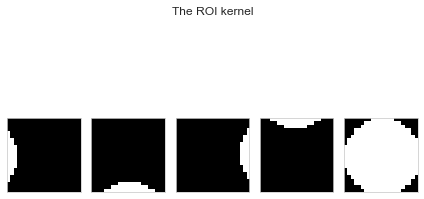

Kernel size: (22, 22)


In [176]:
p = 0.1 # Percentage of the circle to show at each side

kernel = Image.new('1', (diameter, diameter), 0)
draw = ImageDraw(kernel)
draw.ellipse(xy=[((p-1)*diameter, 0), (p*diameter, diameter)], fill=1)
# draw.rectangle((0,0, kernel.width, kernel.height*p), fill=1)
kernels = [kernel]
rotations = [90, 180, 270]
for rot in rotations:
    kernels.append(kernel.rotate(rot))

kernel = Image.new('1', kernel.size, 0)
draw = ImageDraw(kernel)
draw.ellipse(((0,0), (diameter, diameter)), fill=1)
kernels.append(kernel)
# draw.ellipse(xy=[((1-p)*diameter, 0), ((2-p)*diameter, diameter)], fill=1)
# draw.ellipse(xy=[(0, (p-1)*diameter), (diameter, p*diameter)], fill=1)
# draw.ellipse(xy=[(0, (1-p)*diameter), (diameter, (2-p)*diameter)], fill=1)

fig, axs = plt.subplots(1,len(kernels))
for ax, kernel in zip(axs, kernels):
    ax.imshow(kernel)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(None)
fig.suptitle('The ROI kernel')
plt.tight_layout()
plt.show()
print(f'Kernel size: {kernel.size}')

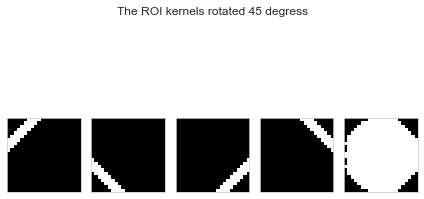

In [171]:
fig, axs = plt.subplots(1,len(kernels))
rot = 45
for ax, kernel in zip(axs, kernels):
    ax.imshow(kernel.rotate(rot))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(None)
fig.suptitle(f'The ROI kernels rotated {rot} degress')
plt.tight_layout()
plt.show()

## Build the prediction tensor

In [48]:
pred_tensor = torch.zeros(wsi.s.dimensions[1]//(pred_patch_size*downsample_factor), wsi.s.dimensions[0]//(pred_patch_size*downsample_factor), requires_grad=False)
print(f'Prediction tensor is of size {pred_tensor.shape}')

Prediction tensor is of size torch.Size([177, 256])


In [49]:
metadata = preds['metadata'].astype(int)
df = pd.DataFrame(data=metadata[:,2:8], columns=preds['metadata_labels'][2:8])
df = df//(pred_patch_size*downsample_factor)
df['pred'] = preds['classification'].astype(int)
df.head()

,tx,ty,cx,cy,bx,by,pred
0,101,0,101,0,102,1,1
1,101,0,102,0,102,1,1
2,102,0,102,0,103,1,1
3,102,0,103,0,103,1,1
4,103,0,103,0,104,1,1


In [50]:
df.pred.value_counts()

7    25580
5    22502
8    17915
0    17142
1    11868
6     9137
4     5857
2     2980
3     1626
Name: pred, dtype: int64

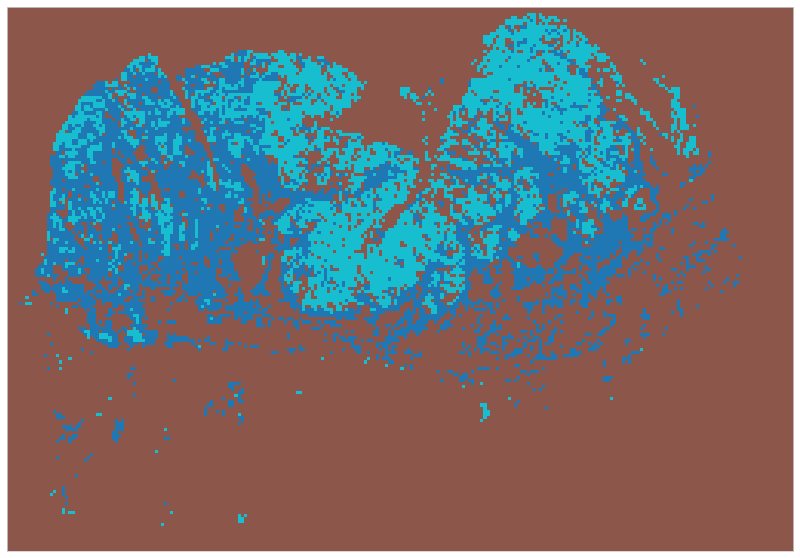

In [134]:
for coords, group in df.groupby(by=['cx', 'cy']):
    # print(group.pred.shape)
    # if len(group.pred.mode()) > 1:
    #     break
    modes = group.pred.mode()
    if 8 in modes.values:
        pred_tensor[coords[::-1]] = 1
    elif 7 in modes.values:
        pred_tensor[coords[::-1]] = -1
    else:
        pred_tensor[coords[::-1]] = 0

pred_tensor = pred_tensor.float()
# for i in range(7):
#     pred_tensor[pred_tensor == i] = 0
# pred_tensor[pred_tensor == 7] = -1
# pred_tensor[pred_tensor == 8] = 1
_, ax = plt.subplots(1, 1, figsize=(15,10))
ax.imshow(pred_tensor, cmap='tab10')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

Kernel: tensor([0., 1.]), torch.Size([5, 1, 22, 22]), torch.float32
Input: tensor([-1.,  0.,  1.]), torch.Size([177, 256]), torch.float32


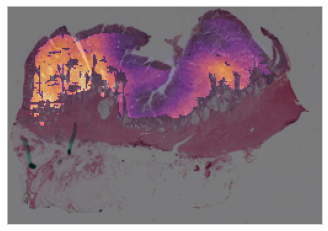

In [181]:
# _, axs = plt.subplots(1, 2)
with torch.no_grad():
    k = torch.concat([T.ToTensor()(x) for x in kernels]).unsqueeze(1)
    # print(pred_tensor.shape)
    # Put the stroma filter to -1
    # k[-1,:,:,:] *= -1
    print(f'Kernel: {torch.unique(k)}, {k.shape}, {k.dtype}')
    # print(k.shape)
    print(f'Input: {torch.unique(pred_tensor)}, {pred_tensor.shape}, {pred_tensor.dtype}')
    # hmaps = F.conv2d(input=(pred_tensor.unsqueeze(0)), weight=k, stride=(1,), padding='same', dilation=(1,)).relu()
    # mask = (hmaps[:4,:,:]>0).sum(0)>=4
    # # hmap = hmaps.mean(0)
    # hmap = hmaps[4,:,:]
    # hmap[~mask] = 0

    mask = (F.conv2d(input=(pred_tensor.unsqueeze(0) == 1).float(), weight=k[:4,:,:], stride=(1,), padding='same', dilation=(1,))>0).sum(0) == 4
    hmap = F.conv2d(input=(pred_tensor.unsqueeze(0) == -1).float(), weight=k[4,:,:].unsqueeze(0), stride=(1,), padding='same', dilation=(1,)).squeeze()
    hmap[~mask] = 0


plt.imshow(preds['thumbnail'].resize(pred_tensor.shape[::-1]))
plt.imshow(hmap, cmap='inferno', alpha=0.5)
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

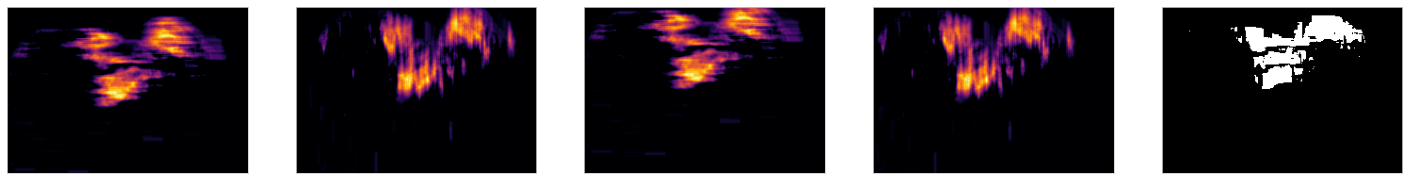

In [173]:
_, axs = plt.subplots(1, 5, figsize=(25,5))
for ax, h in zip(axs[:4], hmaps):
    ax.imshow(h, cmap='inferno')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

axs[4].imshow((hmaps[:4]>0).sum(0)==4, cmap='gray')
axs[4].set_xticks([])
axs[4].set_yticks([])
axs[4].grid(False)
plt.show()

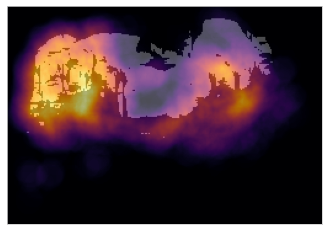

In [180]:
plt.imshow(hmap, cmap='inferno')
plt.imshow(mask, cmap='gray', alpha=0.3)
# plt.imshow(hmaps[4,:,:], cmap='inferno', alpha=0.3)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

tensor([-1., -0.])

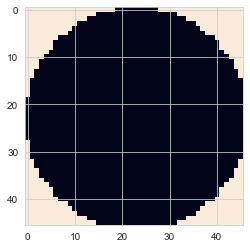

In [34]:
plt.imshow(k[4].squeeze())
torch.unique(k[4])

## With rotations:

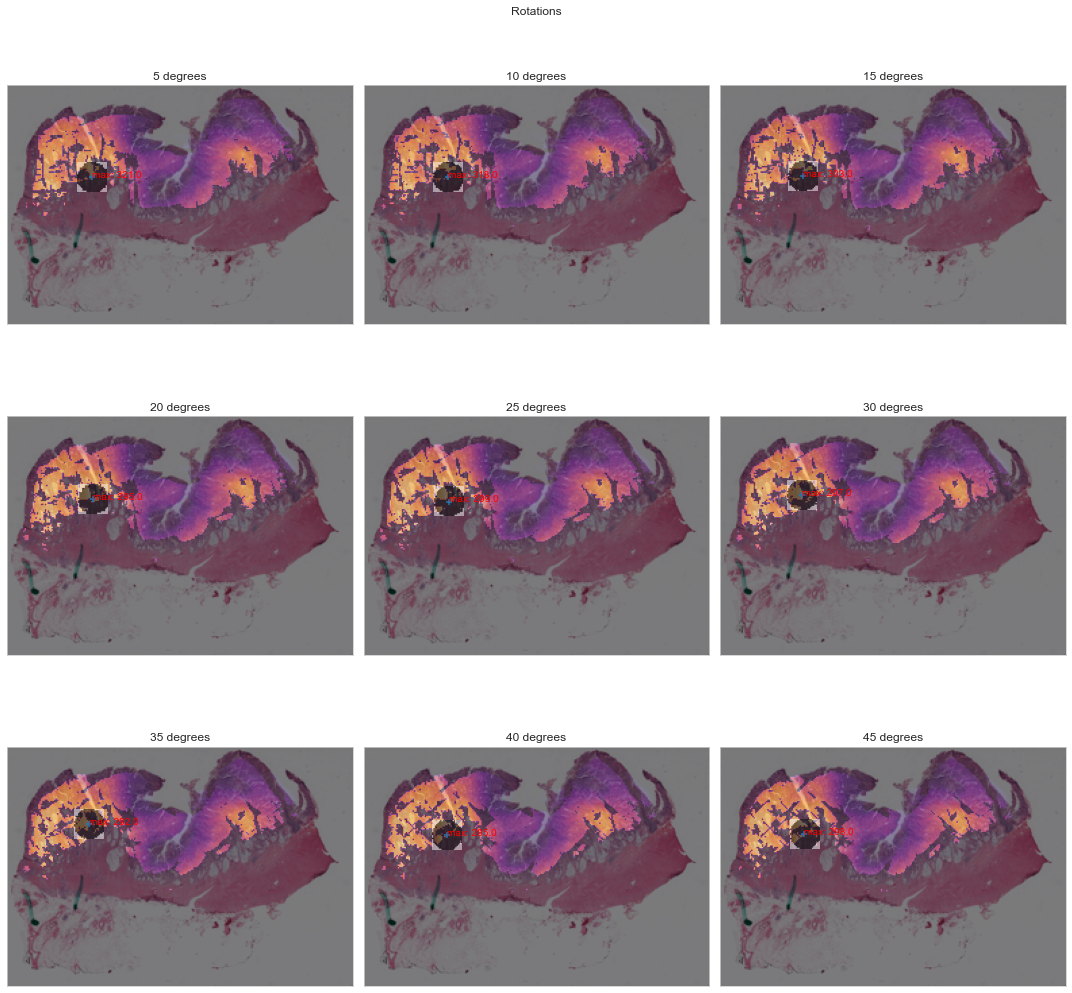

Maximum correlation value is 321.0 found at rotation 5


In [182]:
rotations = np.arange(5,50,5)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Rotations')

offset_x = int(wsi.s.properties.get(openslide.PROPERTY_NAME_BOUNDS_X, 0))
offset_y = int(wsi.s.properties.get(openslide.PROPERTY_NAME_BOUNDS_Y, 0))

centering = 0.5 * wsi.padding_factor * preds['metadata'][0, -2]
maximum = 0
max_idx = 0
xmax, ymax = None, None
thumb = preds['thumbnail'].resize(pred_tensor.shape[::-1])
with torch.no_grad():
    for i, rot in enumerate(rotations):
        k = torch.concat([T.ToTensor()(x.rotate(rot)) for x in kernels]).unsqueeze(1)
        # print(pred_tensor.shape)
        # Put the stroma filter to -1 and 0 on the edges
        # k[-1,:,:,:] *= -1

        # print(f'Kernel: {torch.unique(k)}, {k.shape}, {k.dtype}')
        # print(k.shape)
        # print(f'Input: {torch.unique(pred_tensor)}, {pred_tensor.shape}, {pred_tensor.dtype}')
        # hmaps = F.conv2d(input=pred_tensor.unsqueeze(0), weight=k, stride=(1,), padding='same', dilation=(1,)).relu()
        # mask = (hmaps[:4,:,:]>0).sum(0)==4
        # if not mask.any():
        #     print(f'For rotation {rot} we have no valid areas')
        # hmap = hmaps[4,:,:]
        # hmap = hmaps.mean(0)
        mask = (F.conv2d(input=(pred_tensor.unsqueeze(0) == 1).float(), weight=k[:4,:,:], stride=(1,), padding='same', dilation=(1,))>0).sum(0) == 4
        hmap = F.conv2d(input=(pred_tensor.unsqueeze(0) == -1).float(), weight=k[4,:,:].unsqueeze(0), stride=(1,), padding='same', dilation=(1,)).squeeze()
        hmap[~mask] = 0
        ax = axs[i//3, i%3]
        ax.imshow(thumb)
        ax.imshow(hmap, cmap='inferno', alpha=0.5)
        # sns.heatmap(hmap.relu(), ax=ax, cmap='inferno', vmin=0, vmax=500)

        idx = hmap.argmax().item()
        x = idx%hmap.shape[1]
        y = idx//hmap.shape[1]
        if hmap.max() > maximum:
            maximum = hmap.max()
            max_idx = i
            xmax = x
            ymax = y
        k.squeeze_()
        ax.imshow(k[-1]*-1, alpha=0.5, cmap='gray', extent=(x-k.shape[-1]/2, x+k.shape[-1]/2, y+k.shape[-2]/2, y-k.shape[-2]/2))
        ax.scatter(x, y, marker='+')
        ax.annotate(f'max: {hmap.max()}', (x,y), color='red')
        ax.set_title(f'{rot} degrees')
        ax.grid(None)
        ax.set_xticks([])
        ax.set_yticks([])

    # values = hmap.flatten().sigmoid().numpy()
    #
    # values = np.clip(values, a_min=0, a_max=0.99)
    # bins = np.linspace(0, 1, 101)
    # Abed_utils.save_annotation_qupath(
    #     tx=np.arange(values.shape[0])*pred_patch_size - offset_x + centering,
    #     ty=np.arange(values.shape[0])*pred_patch_size - offset_y + centering,
    #     bx=np.arange(1,values.shape[0]+1)*pred_patch_size - offset_x - centering,
    #     by=np.arange(1,values.shape[0]+1)*pred_patch_size - offset_y - centering,
    #     values=bins[np.digitize(values, bins)],
    #     values_name=bins[np.digitize(values, bins)],
    #     outpath=os.path.join(Abed_utils.OUTPUT_ROOT, 'kernel_heatmaps', f'{os.path.basename(wsi.path)}_{rot}deg.json'),
    #     cmap=cm.get_cmap('inferno')
    # )
plt.tight_layout()
plt.show()

print(f'Maximum correlation value is {maximum} found at rotation {rotations[max_idx]}')

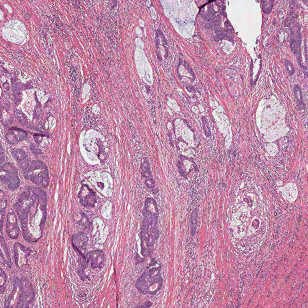

In [183]:
ds_idx = len(wsi.level_downsamples) - 1
ds = int(wsi.level_downsamples[ds_idx])
wsi.s.read_region(((xmax-diameter//2)*pred_patch_size,(ymax-diameter//2)*pred_patch_size), ds_idx, (diameter * pred_patch_size // ds, diameter * pred_patch_size // ds)).convert('RGB')

In [121]:
ds_idx = 0
ds = round(wsi.level_downsamples[ds_idx])
wsi.s.read_region(((xmax-diameter//2)*pred_patch_size,(ymax-diameter//2)*pred_patch_size), ds_idx, (diameter * pred_patch_size // ds, diameter * pred_patch_size // ds)).convert('RGB').save('test.tif')

In [ ]:
x*pred_patch_size, y*pred_patch_size, diameter*pred_patch_size

In [14]:
print(mask.shape)
pd.value_counts(mask.numpy().ravel())

torch.Size([177, 256])


False    42981
True      2331
dtype: int64

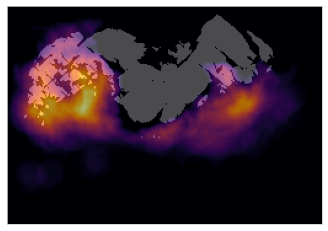

In [184]:
plt.imshow(hmaps[4,:,:], cmap='inferno')
plt.imshow(mask, cmap='gray', alpha=0.3)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [16]:
hmap.flatten().topk(5)

torch.return_types.topk(
values=tensor([52., 52., 35., 33., 22.]),
indices=tensor([ 5450,  5706, 13211, 13467, 13466]))

## Finding the 5 most probable ROIs from all rotation possibilities

In [17]:
rotations = range(0,50,5)
# fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# fig.suptitle('Rotations')
vals = []
xs, ys = [],  []
with torch.no_grad():
    for i, rot in enumerate(rotations):
        k = torch.concat([T.ToTensor()(x.rotate(rot)) for x in kernels]).unsqueeze(1)
        # print(pred_tensor.shape)
        # Put the stroma filter to -1 and 0 on the edges
        k[-1,:,:,:] = -1 + k[:4,:,:,:].sum(0)
        # print(f'Kernel: {torch.unique(k)}, {k.shape}, {k.dtype}')
        # print(k.shape)
        # print(f'Input: {torch.unique(pred_tensor)}, {pred_tensor.shape}, {pred_tensor.dtype}')
        hmaps = F.conv2d(input=pred_tensor.unsqueeze(0), weight=k, stride=(1,), padding='same', dilation=(1,)).relu()
        mask = (hmaps[:4,:,:]>0).sum(0)==4
        hmap = hmaps[4,:,:]
        # hmap = hmaps.mean(0)
        hmap[~mask] = 0

        v, idxs = hmap.flatten().topk(1)
        x, y = idxs%hmap.shape[1], idxs//hmap.shape[1]
        xs.extend(x)
        ys.extend(y)
        vals.extend(v)


        # ax = axs[i//3, i%3]
        # ax.imshow(hmap.relu())
        # ax.set_title(f'{rot} degrees')
        # ax.grid(None)
        # ax.set_xticks([])
        # ax.set_yticks([])
coords = pd.DataFrame(data=list(zip(xs, ys, vals)), columns=['x', 'y', 'value'])
coords = coords.applymap(lambda x: x.item())
coords[['x', 'y']] *= pred_patch_size*downsample_factor
coords.head()

C:\Users\Zace VR\AppData\Local\Temp\ipykernel_1580\2722718798.py:22: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x, y = idxs%hmap.shape[1], idxs//hmap.shape[1]


,x,y,value
0,71680,29120,54.0
1,64512,34944,35.0
2,64064,34944,32.0
3,64512,34944,23.0
4,68096,21952,30.0


In [18]:
print(coords.sort_values(by='value', ascending=False).head(20))

       x      y  value
8  32704   9408   88.0
7  32704   9856   84.0
6  32704   9856   82.0
9  33152   9408   82.0
0  71680  29120   54.0
1  64512  34944   35.0
2  64064  34944   32.0
4  68096  21952   30.0
3  64512  34944   23.0
5  68096  22848    9.0


In [19]:
(coords*wsi.mpp).sort_values(by='value', ascending=False)

,x,y,value
8,8241.408,2370.816,22.176
7,8241.408,2483.712,21.168
6,8241.408,2483.712,20.664
9,8354.304,2370.816,20.664
0,18063.360,7338.240,13.608
1,16257.024,8805.888,8.820
2,16144.128,8805.888,8.064
4,17160.192,5531.904,7.560
3,16257.024,8805.888,5.796
5,17160.192,5757.696,2.268


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Zace VR\AppData\Local\Temp\ipykernel_1580\4121546300.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ax.scatter(idx%hmap.shape[1], idx//hmap.shape[1], marker='+')


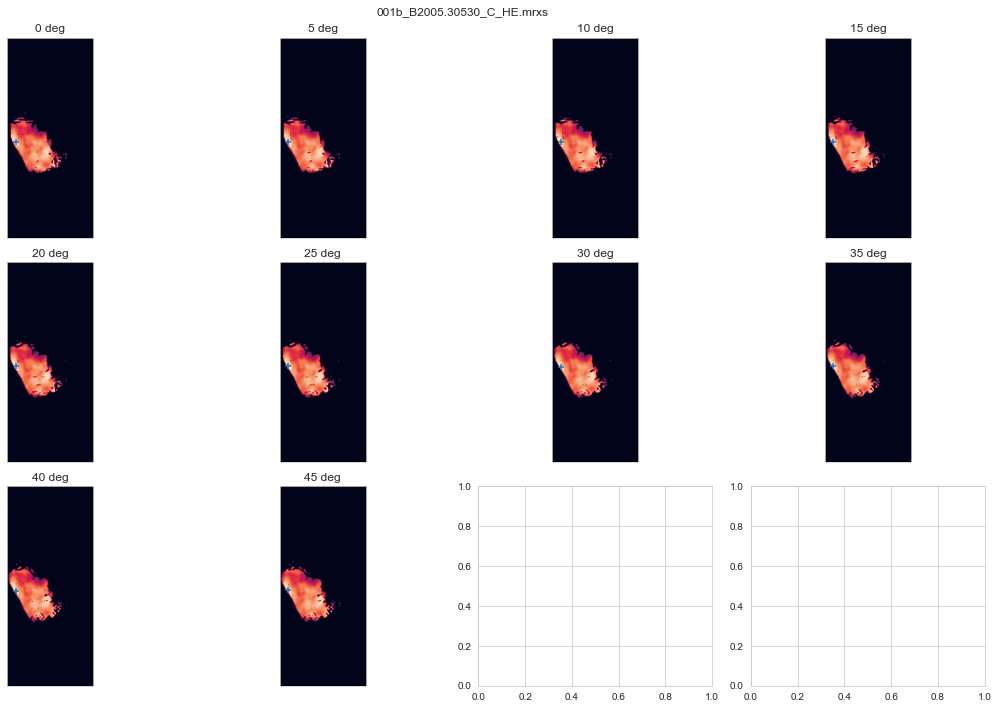

 33%|███▎      | 1/3 [01:49<03:38, 109.47s/it]C:\Users\Zace VR\AppData\Local\Temp\ipykernel_1580\4121546300.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ax.scatter(idx%hmap.shape[1], idx//hmap.shape[1], marker='+')


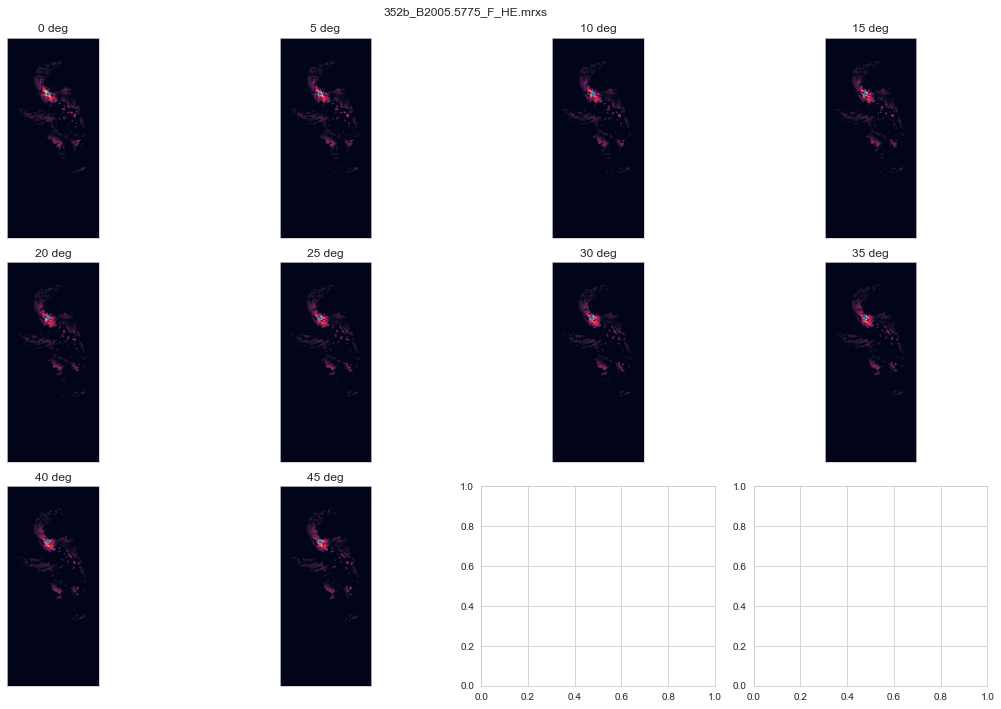

 67%|██████▋   | 2/3 [04:36<02:23, 143.05s/it]C:\Users\Zace VR\AppData\Local\Temp\ipykernel_1580\4121546300.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ax.scatter(idx%hmap.shape[1], idx//hmap.shape[1], marker='+')


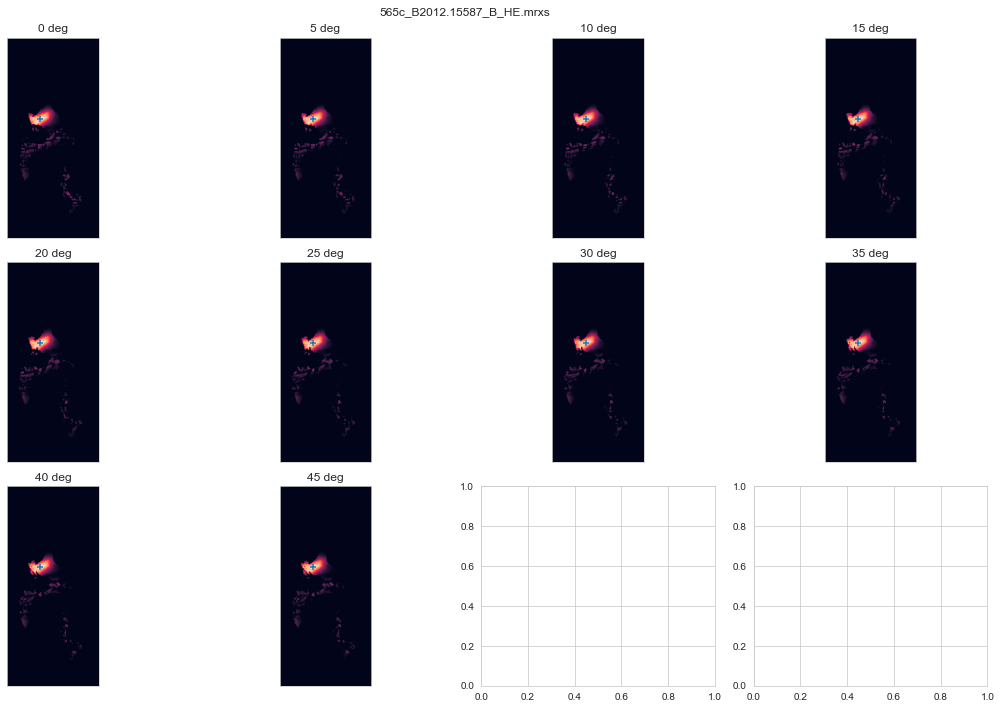

100%|██████████| 3/3 [07:25<00:00, 148.41s/it]


In [186]:
for path in tqdm(glob(os.path.join(Abed_utils.BERN_COHORT_ROOT, '*', '*.mrxs'))):
    wsi = WholeSlideDataset(path)
    preds = np.load(os.path.join(Abed_utils.OUTPUT_ROOT,
                                 'predictions_KNN',
                                 f'{os.path.basename(wsi.path)}_seg_dino_imagenet_100ep_KNN.npy'),
                    allow_pickle=True).item()
    # Fix constants and factors
    pred_patch_size = int(preds['metadata'][0, -2])
    if (preds['metadata'][:, -2] == pred_patch_size).all():
        # print(f'Each patch covers {pred_patch_size}px^2 of the WSI')
        pass
    else:
        raise RuntimeError('Not all patches are of the same size!')

    downsample_factor = 1

    patch_size = wsi.mpp * downsample_factor * pred_patch_size  # [um/patch]
    diameter = round(2500 / patch_size)  # [patch]
    search_radius = round(500 / patch_size)  # [patch]

    # Build convolution kernel
    p = 0.15  # Percentage of the circle to show at each side

    kernel = Image.new('1', (diameter, diameter), 0)
    draw = ImageDraw(kernel)
    draw.ellipse(xy=[((p-1)*diameter, 0), (p*diameter, diameter)], fill=1)
    kernels = [kernel]
    rotations = [90, 180, 270]
    for rot in rotations:
        kernels.append(kernel.rotate(rot))

    kernel = Image.new('1', kernel.size, 0)
    draw = ImageDraw(kernel)
    draw.ellipse(((0,0), (diameter, diameter)), fill=1)
    kernels.append(kernel)

    # Build prediction tensor
    pred_tensor = torch.zeros(wsi.s.dimensions[1] // (pred_patch_size * downsample_factor),
                              wsi.s.dimensions[0] // (pred_patch_size * downsample_factor))
    # print(f'Prediction tensor is of size {pred_tensor.shape}')

    metadata = preds['metadata'].astype(int)
    df = pd.DataFrame(data=metadata[:, 2:8], columns=preds['metadata_labels'][2:8])
    df = df // (pred_patch_size * downsample_factor)
    df['pred'] = preds['classification'].astype(int)

    # Put 1 wherever we have a tumor, -1 for Stroma, and 0 for everything else
    for coords, group in df.groupby(by=['cx', 'cy']):
        modes = group.pred.mode()
        if 7 in modes.values:
            pred_tensor[coords[::-1]] = -1
        elif 8 in modes.values:
            pred_tensor[coords[::-1]] = 1
        else:
            pred_tensor[coords[::-1]] = 0

    rotations = range(0, 50, 5)
    # fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    # fig.suptitle('Rotations')
    vals = []
    xs, ys = [], []
    fig, axs = plt.subplots(3, 4, figsize=(15,10))
    fig.suptitle(os.path.basename(path))
    with torch.no_grad():
        for i, rot in enumerate(rotations):
            k = torch.concat([T.ToTensor()(x.rotate(rot)) for x in kernels]).unsqueeze(1)
            # k[-1, :, :, :] *= -1
            # print(pred_tensor.shape)
            # Put the stroma filter to -1 and 0 on the edges
            # str_filter = torch.zeros_like(k[0]) - 1 + k.sum(0)
            # k = torch.concat([k, str_filter.unsqueeze(0)], dim=0)
            # k[-1,:,:,:] = -1 + k[:-1,:,:,:].sum(0)
            # print(k.shape)
            # print(f'Kernel: {torch.unique(k)}, {k.shape}, {k.dtype}')
            # print(k.shape)
            # print(f'Input: {torch.unique(pred_tensor)}, {pred_tensor.shape}, {pred_tensor.dtype}')
            # hmaps = F.conv2d(input=pred_tensor.unsqueeze(0), weight=k, stride=(1,), padding='same', dilation=(1,)).relu()
            # mask = (hmaps[:4,:,:]>0).sum(0)==4
            # hmap = hmaps[4,:,:]
            mask = (F.conv2d(input=(pred_tensor.unsqueeze(0) == 1).float(), weight=k[:4,:,:], stride=(1,), padding='same', dilation=(1,))>0).sum(0) == 4
            hmap = F.conv2d(input=(pred_tensor.unsqueeze(0) == -1).float(), weight=k[4,:,:].unsqueeze(0), stride=(1,), padding='same', dilation=(1,)).squeeze()
            # hmap = hmaps.mean(0)
            hmap[~mask] = 0

            ax = axs[i//4, i%4]
            ax.imshow(hmap.relu())
            ax.set_title(f'{rot} deg')
            ax.grid(None)
            ax.set_xticks([])
            ax.set_yticks([])
            idx = hmap.argmax()
            ax.scatter(idx%hmap.shape[1], idx//hmap.shape[1], marker='+')
            # v, idxs = hmap.flatten().topk(1)
            # x, y = idxs % hmap.shape[1], idxs // hmap.shape[1]
            # xs.extend(x)
            # ys.extend(y)
            # vals.extend(v)

            # ax = axs[i//3, i%3]
            # ax.imshow(hmap.relu())
            # ax.set_title(f'{rot} degrees')
            # ax.grid(None)
            # ax.set_xticks([])
            # ax.set_yticks([])
        plt.tight_layout()
        plt.show()
    # coords = pd.DataFrame(data=list(zip(xs, ys, vals)), columns=['x', 'y', 'value'])
    # coords = coords.applymap(lambda x: x.item())
    # coords[['x', 'y']] *= pred_patch_size * downsample_factor

In [132]:
wsi.level_downsamples, wsi.level_magnifications

((1.0, 4.000042546150883, 16.000448196471062, 32.000896392942124),
 array([40.  , 10.  ,  2.5 ,  1.25]))